<a href="https://colab.research.google.com/github/edwardcdy/deep-learning-notebooks/blob/main/Machine_Translation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn, Tensor
from torch.utils.data import dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR

from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

import tqdm

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     |████████████████████████████████| 6.0 MB 8.4 MB/s 
     |████████████████████████████████| 451 kB 38.9 MB/s 
     |████████████████████████████████| 628 kB 49.1 MB/s 
     |████████████████████████████████| 181 kB 50.1 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 10.1 MB 48.4 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 13.9 M

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List


SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
BATCH_SIZE = 32

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_data = to_map_style_dataset(train_iter)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def scale_transpose_seqs(x: torch.Tensor, y: torch.Tensor, max_length: int = 30):
  if x.shape[0] < max_length:
    add = torch.full((max_length - x.shape[0], x.shape[1]), PAD_IDX)
    x = torch.cat((x, add), dim=0)
  elif x.shape[0] > max_length:
    x = x[:max_length, :]

  if y.shape[0] < max_length:
    add = torch.full((max_length - y.shape[0], y.shape[1]), PAD_IDX)
    y = torch.cat((y, add), dim=0)
  elif y.shape[0] > max_length:
    y = y[:max_length, :]

  return x.to(device).long().T, y.to(device).long().T

In [ ]:

BATCH_SIZE = 1

valid_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
valid_dataloader = DataLoader(to_map_style_dataset(valid_iter), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)


def example_translations(net: nn.Module, n_samples: int): 
  net.eval()

  english = vocab_transform[TGT_LANGUAGE].get_itos()
  german = vocab_transform[SRC_LANGUAGE].get_itos()

  count = 0
  for x,y in valid_dataloader:
    print(f'Source sentence: {" ".join(map(lambda a: german[a], x))}')
    print(f'Ground truth: {" ".join(map(lambda a: english[a], y))}')
    x, _ = scale_transpose_seqs(x,y, 20)
    out = net(x)

    print(f'Translated sentence: {" ".join(map(lambda a: english[a.argmax()], out.squeeze()))}')
    print("\n")
    count += 1
    if count == n_samples:
      break


# Simple feedforward model

In [ ]:
class FF(nn.Module):
  
  def __init__(self, input_vocab_size: int, target_vocab_size: int, max_seq_len: int = 30):
    super().__init__()
    self.lookup = nn.Embedding(input_vocab_size, 10)
    self.fc1 = nn.Linear(max_seq_len * 10, max_seq_len * 20)
    self.fc2 = nn.Linear(max_seq_len * 20, max_seq_len * 20)
    self.fc3 = nn.Linear(max_seq_len * 20, max_seq_len * target_vocab_size)

  def forward(self, x):
    batch_size, max_seq_len = x.shape
    embedded = self.lookup(x)
    x = embedded.reshape(batch_size, max_seq_len * 10)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x).reshape((batch_size, max_seq_len, -1))
    return F.log_softmax(x, dim=2)


In [ ]:
def train(net: nn.Module, epochs: int = 20):
  net.train()
  opt = torch.optim.Adam(net.parameters(), lr=3e-4)
  loss = torch.nn.NLLLoss()

  ret = []

  for e in tqdm.tqdm(range(epochs)):
    t = 0


    for x,y in train_dataloader:
      net.zero_grad()

      x, y = scale_transpose_seqs(x, y)

      out = net(x)

      l = loss(out.swapaxes(1,2), y)

      l.backward()
      opt.step()

      t += l.item()

    ret.append(t)

    if e % 5 == 0:
      print(f"Epoch {e}: loss {t}")

  return ret


In [ ]:
in_vocab = len(vocab_transform[SRC_LANGUAGE])
out_vocab = len(vocab_transform[TGT_LANGUAGE])

net = FF(in_vocab, out_vocab).to(device)

errors = train(net, 50)

  2%|▏         | 1/50 [00:50<41:14, 50.51s/it]

Epoch 0: loss 2404.579223513603


 12%|█▏        | 6/50 [05:01<36:51, 50.25s/it]

Epoch 5: loss 1262.70050573349


 22%|██▏       | 11/50 [09:13<32:40, 50.28s/it]

Epoch 10: loss 830.6038464307785


 32%|███▏      | 16/50 [13:24<28:29, 50.27s/it]

Epoch 15: loss 630.0603826195002


 42%|████▏     | 21/50 [17:35<24:18, 50.29s/it]

Epoch 20: loss 501.1322252303362


 52%|█████▏    | 26/50 [21:47<20:07, 50.31s/it]

Epoch 25: loss 403.76430977880955


 62%|██████▏   | 31/50 [25:59<15:55, 50.31s/it]

Epoch 30: loss 326.6455256268382


 72%|███████▏  | 36/50 [30:10<11:43, 50.27s/it]

Epoch 35: loss 262.72930435836315


 82%|████████▏ | 41/50 [34:21<07:32, 50.26s/it]

Epoch 40: loss 209.008991997689


 92%|█████████▏| 46/50 [38:32<03:20, 50.18s/it]

Epoch 45: loss 166.3835297934711


100%|██████████| 50/50 [41:53<00:00, 50.26s/it]


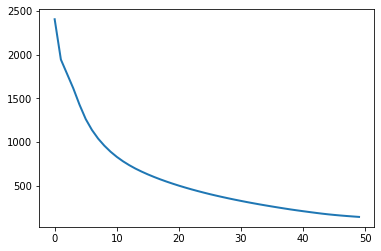

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# plot
fig, ax = plt.subplots()
ax.plot(np.arange(50), errors, linewidth=2.0)
plt.show()

In [ ]:
example_translations(net, 5)

Source sentence: <bos> Ein Mann mit <unk> <unk> sein Ohr , um ein <unk> hören zu können . <eos>
Ground truth: <bos> A man with dreadlocks is plugging his ear to hear a phone call . <eos>
Translated sentence: <bos> A man in a blue , music a to sign a , , . him <pad> . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


Source sentence: <bos> Ein <unk> Mann schläft draußen auf seinem Stuhl . <eos>
Ground truth: <bos> A half naked man is sleeping on his chair outdoors . <eos>
Translated sentence: <bos> A solitary man is at man on in . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


Source sentence: <bos> Ein Mann in einem weißen T-Shirt und Khakihosen kauert auf einem umgestürzten Baumstamm . <eos>
Ground truth: <bos> A man in a white shirt and khaki pants crouches on a fallen tree trunk . <eos>
Translated sentence: <bos> A in with a green t - shirt is on overalls a and orange <eos> . <eos> <pa

# RNNs

In [ ]:
class SimpleRNN(nn.Module):
  
  def __init__(self, input_vocab_size: int, target_vocab_size: int, seq_len: int = 20):
    super().__init__()

    word_vec_size = 10

    self.lookup = nn.Embedding(input_vocab_size, word_vec_size)
    self.rnn = nn.RNN(word_vec_size, word_vec_size, 1, batch_first = True)
    self.fc = nn.Linear(seq_len * word_vec_size, target_vocab_size * seq_len)

  def forward(self, x):
    batch_size, max_seq_len = x.shape
    embedded = self.lookup(x)
    x = self.rnn(embedded)[0].reshape(batch_size, -1)
    x = self.fc(x).reshape((batch_size, max_seq_len, -1))
    return F.log_softmax(x, dim=2)


In [ ]:
class SimpleLSTM(nn.Module):
  
  def __init__(self, input_vocab_size: int, target_vocab_size: int, seq_len: int = 20):
    super().__init__()

    word_vec_size = 10

    self.lookup = nn.Embedding(input_vocab_size, word_vec_size)
    self.LSTM = nn.LSTM(word_vec_size, word_vec_size, 1, batch_first = True)
    self.fc = nn.Linear(seq_len * word_vec_size, target_vocab_size * seq_len)

  def forward(self, x):
    batch_size, max_seq_len = x.shape
    embedded = self.lookup(x)
    x = self.LSTM(embedded)[0].reshape(batch_size, -1)
    x = self.fc(x).reshape((batch_size, max_seq_len, -1))
    return F.log_softmax(x, dim=2)

In [ ]:
class SimpleGRU(nn.Module):
  
  def __init__(self, input_vocab_size: int, target_vocab_size: int, seq_len: int = 20):
    super().__init__()

    word_vec_size = 10

    self.lookup = nn.Embedding(input_vocab_size, word_vec_size)
    self.gru = nn.GRU(word_vec_size, word_vec_size, 1, batch_first = True)
    self.fc = nn.Linear(seq_len * word_vec_size, target_vocab_size * seq_len)

  def forward(self, x):
    batch_size, max_seq_len = x.shape
    embedded = self.lookup(x)
    x = self.gru(embedded)[0].reshape(batch_size, -1)
    x = self.fc(x).reshape((batch_size, max_seq_len, -1))
    return F.log_softmax(x, dim=2)

In [ ]:
def valid_eval(net: nn.Module):
  net.eval()
  loss = torch.nn.NLLLoss()
  total = 0

  for x,y in valid_dataloader:

      x, y = scale_transpose_seqs(x, y, 20)
      out = net(x)

      total += float(loss(out.swapaxes(1,2), y))
    
  return total


def train(net: nn.Module, epochs: int = 20, lr: float= 3e-4):
  net.train()
  opt = torch.optim.Adam(net.parameters(), lr=lr)
  loss = torch.nn.NLLLoss()
  scheduler = ExponentialLR(opt, gamma=0.95)

  ret = [[],[]]


  for e in tqdm.tqdm(range(epochs)):
    t = 0
    net.train()
    for x,y in train_dataloader:
      net.zero_grad()

      x, y = scale_transpose_seqs(x, y, 20)
      out = net(x)

      l = loss(out.swapaxes(1,2), y)

      l.backward()
      opt.step()

      t += float(l)
    scheduler.step()

    ret[0].append(t)

    ret[1].append(valid_eval(net))

    if e % 5 == 0:
      print(f"Epoch {e} - loss: {t}, valid loss: {ret[1][e]}")

  return ret


In [ ]:
in_vocab = len(vocab_transform[SRC_LANGUAGE])
out_vocab = len(vocab_transform[TGT_LANGUAGE])

In [ ]:
epochs = 80

net = SimpleRNN(in_vocab, out_vocab).to(device)
train_data = train(net, epochs, lr=1e-4)

  1%|▏         | 1/80 [00:20<26:33, 20.17s/it]

Epoch 0 - loss: 4661.8976328372955, valid loss: 3854.8191908597946


  8%|▊         | 6/80 [01:58<24:19, 19.73s/it]

Epoch 5 - loss: 2955.0680277347565, valid loss: 3610.991071343422


 14%|█▍        | 11/80 [03:36<22:32, 19.60s/it]

Epoch 10 - loss: 2712.7804787158966, valid loss: 3571.879125356674


 20%|██        | 16/80 [05:14<20:50, 19.53s/it]

Epoch 15 - loss: 2516.983368873596, valid loss: 3569.069273531437


 26%|██▋       | 21/80 [06:51<19:11, 19.52s/it]

Epoch 20 - loss: 2347.814858198166, valid loss: 3567.325751066208


 32%|███▎      | 26/80 [08:29<17:32, 19.48s/it]

Epoch 25 - loss: 2200.844597697258, valid loss: 3569.672935664654


 39%|███▉      | 31/80 [10:06<15:55, 19.49s/it]

Epoch 30 - loss: 2075.2904595136642, valid loss: 3577.270637214184


 45%|████▌     | 36/80 [11:44<14:16, 19.48s/it]

Epoch 35 - loss: 1968.452109694481, valid loss: 3588.5591846704483


 51%|█████▏    | 41/80 [13:21<12:40, 19.50s/it]

Epoch 40 - loss: 1877.1158694028854, valid loss: 3602.7425268292427


 57%|█████▊    | 46/80 [14:59<11:02, 19.49s/it]

Epoch 45 - loss: 1798.4092552661896, valid loss: 3619.4965113401413


 64%|██████▍   | 51/80 [16:36<09:25, 19.50s/it]

Epoch 50 - loss: 1730.3070110082626, valid loss: 3638.4403369426727


 70%|███████   | 56/80 [18:14<07:49, 19.55s/it]

Epoch 55 - loss: 1670.9909026622772, valid loss: 3658.988529086113


 76%|███████▋  | 61/80 [19:51<06:10, 19.50s/it]

Epoch 60 - loss: 1618.9496392011642, valid loss: 3680.7163896262646


 82%|████████▎ | 66/80 [21:29<04:32, 19.49s/it]

Epoch 65 - loss: 1572.9516566991806, valid loss: 3703.360098838806


 89%|████████▉ | 71/80 [23:06<02:55, 19.46s/it]

Epoch 70 - loss: 1532.0015263557434, valid loss: 3726.7149617373943


 95%|█████████▌| 76/80 [24:43<01:17, 19.48s/it]

Epoch 75 - loss: 1495.2993504405022, valid loss: 3750.6488991975784


100%|██████████| 80/80 [26:01<00:00, 19.52s/it]


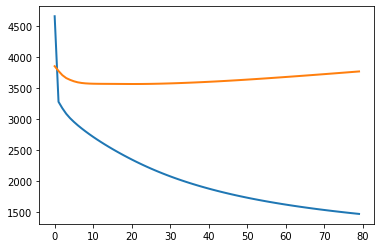

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# plot
fig, ax = plt.subplots()
ax.plot(np.arange(epochs), train_data[0], linewidth=2.0)
ax.plot(np.arange(epochs), train_data[1], linewidth=2.0)
plt.show()


In [ ]:
example_translations(net, 5)

Source sentence: <bos> Ein Mann in einem roten Kapuzenpullover und einer weißen Schürze steht vor einem Wandgemälde . <eos>
Ground truth: <bos> A man in a red hoodie with a white apron stands in front of a mural . <eos>
Translated sentence: <bos> A man in a red shirt and a jeans a a a a a <eos> . <pad> <pad> <pad>


Source sentence: <bos> Drei Männer gehen auf einer Straße in den Bergen . <eos>
Ground truth: <bos> Three men are walking on a road in the mountains . <eos>
Translated sentence: <bos> Three men are walking a street street the street . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


Source sentence: <bos> Vier Frauen haben sich mit lustigen Kostümen verkleidet . <eos>
Ground truth: <bos> Four women dressed up in funny costumes . <eos>
Translated sentence: <bos> Four women are near with a a . . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


Source sentence: <bos> Eine Frau konzentriert sich auf ihr <unk> . <eos>
Ground truth: <bos> A woman is <unk> on h

In [ ]:
epochs = 80

lstm_net = SimpleLSTM(in_vocab, out_vocab).to(device)
train_data = train(lstm_net, epochs, lr=3e-4)

  1%|▏         | 1/80 [00:19<26:00, 19.76s/it]

Epoch 0 - loss: 4020.6581320762634, valid loss: 3732.0395060777664


  8%|▊         | 6/80 [01:58<24:20, 19.74s/it]

Epoch 5 - loss: 2729.494853258133, valid loss: 3525.2702201008797


 14%|█▍        | 11/80 [03:37<22:45, 19.79s/it]

Epoch 10 - loss: 2372.0431818962097, valid loss: 3526.538954138756


 20%|██        | 16/80 [05:16<21:05, 19.78s/it]

Epoch 15 - loss: 2170.7551621198654, valid loss: 3534.009102165699


 26%|██▋       | 21/80 [06:55<19:27, 19.79s/it]

Epoch 20 - loss: 2045.3694424629211, valid loss: 3539.7033920288086


 32%|███▎      | 26/80 [08:34<17:47, 19.77s/it]

Epoch 25 - loss: 1961.9253494739532, valid loss: 3545.9161723852158


 39%|███▉      | 31/80 [10:12<16:04, 19.69s/it]

Epoch 30 - loss: 1903.8085376024246, valid loss: 3552.3231130838394


 45%|████▌     | 36/80 [11:50<14:24, 19.65s/it]

Epoch 35 - loss: 1862.1271376609802, valid loss: 3557.9817864894867


 51%|█████▏    | 41/80 [13:29<12:47, 19.69s/it]

Epoch 40 - loss: 1831.6314188241959, valid loss: 3562.621408700943


 57%|█████▊    | 46/80 [15:07<11:09, 19.70s/it]

Epoch 45 - loss: 1808.9948484897614, valid loss: 3566.437480390072


 64%|██████▍   | 51/80 [16:46<09:30, 19.67s/it]

Epoch 50 - loss: 1792.0102190971375, valid loss: 3569.5672820210457


 70%|███████   | 56/80 [18:24<07:52, 19.67s/it]

Epoch 55 - loss: 1779.1640578508377, valid loss: 3572.1066384911537


 76%|███████▋  | 61/80 [20:02<06:13, 19.66s/it]

Epoch 60 - loss: 1769.390922665596, valid loss: 3574.146080315113


 82%|████████▎ | 66/80 [21:40<04:34, 19.63s/it]

Epoch 65 - loss: 1761.9240429401398, valid loss: 3575.772286295891


 89%|████████▉ | 71/80 [23:18<02:56, 19.64s/it]

Epoch 70 - loss: 1756.2012264728546, valid loss: 3577.064542710781


 95%|█████████▌| 76/80 [24:57<01:18, 19.63s/it]

Epoch 75 - loss: 1751.8050158023834, valid loss: 3578.0858237743378


100%|██████████| 80/80 [26:15<00:00, 19.69s/it]


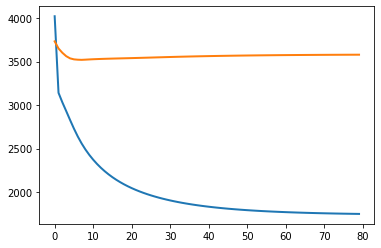

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# plot
fig, ax = plt.subplots()
ax.plot(np.arange(epochs), train_data[0], linewidth=2.0)
ax.plot(np.arange(epochs), train_data[1], linewidth=2.0)
plt.show()


In [ ]:
example_translations(lstm_net, 5)

Source sentence: <bos> Ein kleines Kind spielt unter einem Rasensprenger . <eos>
Ground truth: <bos> A young child is playing in a water sprinkler . <eos>
Translated sentence: <bos> A young child is playing a a . . . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


Source sentence: <bos> Eine Person trägt viele Taschen . <eos>
Ground truth: <bos> A person is carrying many bags . <eos>
Translated sentence: <bos> A person is a in a . . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


Source sentence: <bos> Eine <unk> Dame mit einer blauen Tasche fährt auf einem Roller . <eos>
Ground truth: <bos> A white blond lady wearing a blue bag riding a scooter . <eos>
Translated sentence: <bos> A woman lady with a blue shirt is a a a . . <eos> <pad> <pad> <pad> <pad> <pad>


Source sentence: <bos> Ein stehender Mann hält ein Mikrofon vor einem Mann mit einer Gitarre . <eos>
Ground truth: <bos> A standing man holds a microphone in front of a man holding a guitar . <eos>
Tra

  2%|▎         | 1/40 [00:19<12:53, 19.83s/it]

Epoch 0 - loss: 3899.3319289684296, valid loss: 3694.753669857979


 15%|█▌        | 6/40 [01:58<11:11, 19.74s/it]

Epoch 5 - loss: 2604.708069086075, valid loss: 3501.918863236904


 28%|██▊       | 11/40 [03:37<09:35, 19.83s/it]

Epoch 10 - loss: 2227.8103506565094, valid loss: 3531.4803797006607


 40%|████      | 16/40 [05:16<07:53, 19.71s/it]

Epoch 15 - loss: 2011.6092076301575, valid loss: 3559.2357252836227


 52%|█████▎    | 21/40 [06:54<06:14, 19.72s/it]

Epoch 20 - loss: 1880.4954221248627, valid loss: 3577.104872107506


 65%|██████▌   | 26/40 [08:33<04:36, 19.73s/it]

Epoch 25 - loss: 1795.2420711517334, valid loss: 3594.519650876522


 78%|███████▊  | 31/40 [10:11<02:57, 19.73s/it]

Epoch 30 - loss: 1737.2040234804153, valid loss: 3610.1438831686974


 90%|█████████ | 36/40 [11:52<01:19, 19.89s/it]

Epoch 35 - loss: 1696.3671085834503, valid loss: 3622.8947525024414


100%|██████████| 40/40 [13:11<00:00, 19.78s/it]


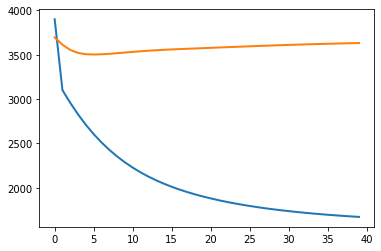

In [ ]:
epochs = 40

gru_net = SimpleGRU(in_vocab, out_vocab).to(device)
train_data = train(gru_net, epochs, lr=3e-4)

import matplotlib.pyplot as plt
import numpy as np
# plot
fig, ax = plt.subplots()
ax.plot(np.arange(epochs), train_data[0], linewidth=2.0)
ax.plot(np.arange(epochs), train_data[1], linewidth=2.0)
plt.show()

In [ ]:
example_translations(gru_net, 5)

Source sentence: <bos> Ein Mann trägt ein Kind auf seinen Schultern , während um ihn herum Menschen gehen . <eos>
Ground truth: <bos> A man holds a child on his shoulders as a people walk around him . <eos>
Translated sentence: <bos> A man is a a soccer a a , while , the . <eos> . <pad> <pad> <pad> <pad>


Source sentence: <bos> Zwei Männer bauen eine blaue <unk> auf einem <unk> See auf <eos>
Ground truth: <bos> Two men setting up a blue ice fishing hut on an iced over lake <eos>
Translated sentence: <bos> Two men are in a a a a a a . <eos> <eos> <pad> <pad> <pad> <pad> <pad> <pad>


Source sentence: <bos> Blick in eine Straße , die von großen , sauberen Gebäuden gesäumt wird . <eos>
Ground truth: <bos> A view of a street lined with large , clean buildings . <eos>
Translated sentence: <bos> The woman of of a the the street the the . . <pad> <pad> <pad> <pad> <pad> <pad> <pad>


Source sentence: <bos> Eine blonde Frau mit braunem Cowboyhut macht eine obszöne Geste in Richtung der Kamera

 10%|█         | 1/10 [00:19<02:57, 19.74s/it]

Epoch 0 - loss: 3921.875874042511, valid loss: 3688.1374564170837


 60%|██████    | 6/10 [01:58<01:19, 19.82s/it]

Epoch 5 - loss: 2538.739069223404, valid loss: 3484.9941712617874


100%|██████████| 10/10 [03:18<00:00, 19.81s/it]


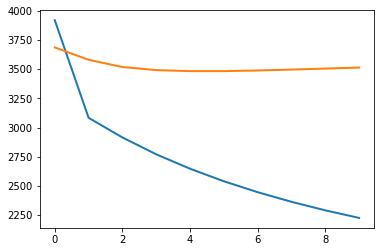

In [79]:
epochs = 10

gru_net = SimpleGRU(in_vocab, out_vocab).to(device)
train_data = train(gru_net, epochs, lr=3e-4)

import matplotlib.pyplot as plt
import numpy as np
# plot
fig, ax = plt.subplots()
ax.plot(np.arange(epochs), train_data[0], linewidth=2.0)
ax.plot(np.arange(epochs), train_data[1], linewidth=2.0)
plt.show()

In [80]:
example_translations(gru_net, 5)

Source sentence: <bos> Eine Frau mit blauem Hut und gelbem Rock springt an einer mit <unk> bewachsenen Stelle in die Luft . <eos>
Ground truth: <bos> A woman in a blue hat and yellow skirt is jumping in an area with <unk> . <eos>
Translated sentence: <bos> A woman with a red and and a a a a a in a her a . <pad> <pad>


Source sentence: <bos> Mann beobachtet eine Frau , die auf dem Gehweg raucht . <eos>
Ground truth: <bos> Man looking at a woman that is smoking on the sidewalk . <eos>
Translated sentence: <bos> Man black walking walking woman on on on a . . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


Source sentence: <bos> Ein Sohn und seine Eltern nehmen ein Gruppenfoto in einer Kirche auf . <eos>
Ground truth: <bos> A son and his parents are taking a group picture in a church . <eos>
Translated sentence: <bos> A young and is a a a a a a a . . . <pad> <pad> <pad> <pad> <pad>


Source sentence: <bos> Ein Mann mit schwarzer Jacke und schwarzer Mütze spielt auf einer Trompete . <eos